# Task 2: Time Series Forecasting Models

This notebook implements and compares ARIMA and LSTM models for Tesla stock price forecasting.

## Objectives:
1. Prepare data with chronological train/test split
2. Implement ARIMA model (with manual fallback if pmdarima fails)
3. Build LSTM deep learning model 
4. Compare performance using MAE, RMSE, MAPE
5. Generate forecasts and save results


In [18]:
# Import libraries with pmdarima fallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta

# Statistical modeling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Try pmdarima, fallback to manual ARIMA if it fails
try:
    import pmdarima as pm
    PMDARIMA_AVAILABLE = True
    print("✅ pmdarima available")
except Exception as e:
    PMDARIMA_AVAILABLE = False
    print("⚠️ pmdarima failed, using manual ARIMA")
    print(f"Error: {type(e).__name__}")

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Setup
np.random.seed(42)
tf.random.set_seed(42)
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"TensorFlow: {tf.__version__}")
print(f"pmdarima available: {PMDARIMA_AVAILABLE}")


⚠️ pmdarima failed, using manual ARIMA
Error: ValueError
Libraries imported successfully!
TensorFlow: 2.19.0
pmdarima available: False


In [19]:
import os
from pathlib import Path

print(f"Current working directory: {os.getcwd()}")

# Handle both running from project root or notebooks directory
if 'notebooks' in os.getcwd() and os.path.exists('../data/processed'):
    data_path = '../data/processed/'
    models_path = '../models/'
else:
    data_path = 'data/processed/'
    models_path = 'models/'

print(f"Using data path: {data_path}")

# Ensure directories exist
Path(data_path).mkdir(parents=True, exist_ok=True)
Path(models_path).mkdir(parents=True, exist_ok=True)

try:
    # Load Tesla processed data
    tsla_data = pd.read_csv(f'{data_path}tsla_processed.csv', index_col=0, parse_dates=True)
    tsla_returns = pd.read_csv(f'{data_path}tsla_returns.csv', index_col=0, parse_dates=True)
    
    print("Data loaded successfully!")
    print(f"Tesla data shape: {tsla_data.shape}")
    print(f"Date range: {tsla_data.index.min()} to {tsla_data.index.max()}")
    print(f"Tesla returns shape: {tsla_returns.shape}")
    
    # Focus on Tesla Close prices and returns for forecasting
    tsla_prices = tsla_data['Close'].dropna()
    tsla_daily_returns = tsla_returns['Close'].dropna()  # Returns are in 'Close' column
    
    print(f"\\nTesla prices: {len(tsla_prices)} observations")
    print(f"Price range: ${tsla_prices.min():.2f} - ${tsla_prices.max():.2f}")
    
    display(tsla_data.head())
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure Task 1 has been completed and processed data files exist.")


Current working directory: /Users/mikiyasegaye/MK_Lab/10 Academy/gmf-time-series-forecasting/notebooks
Using data path: ../data/processed/
Data loaded successfully!
Tesla data shape: (2285, 8)
Date range: 2015-07-01 00:00:00 to 2024-07-30 00:00:00
Tesla returns shape: (2284, 1)
\nTesla prices: 2285 observations
Price range: $9.58 - $409.97


,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2015-07-01,18.073999,18.174667,17.856667,17.943333,17.943333,31518000,0.0,0.0
2015-07-02,18.680000,18.830000,18.220667,18.667999,18.667999,107458500,0.0,0.0
2015-07-06,18.591999,18.779333,18.420000,18.648001,18.648001,61828500,0.0,0.0
2015-07-07,18.333332,18.346666,17.384666,17.858667,17.858667,91576500,0.0,0.0
2015-07-08,17.288000,17.386667,16.954000,16.997334,16.997334,93316500,0.0,0.0


Chronological data split completed:
Training period: 2015-07-01 00:00:00 to 2022-12-30 00:00:00
Testing period: 2023-01-03 00:00:00 to 2024-07-30 00:00:00
Training samples: 1890 (82.7%)
Testing samples: 395 (17.3%)


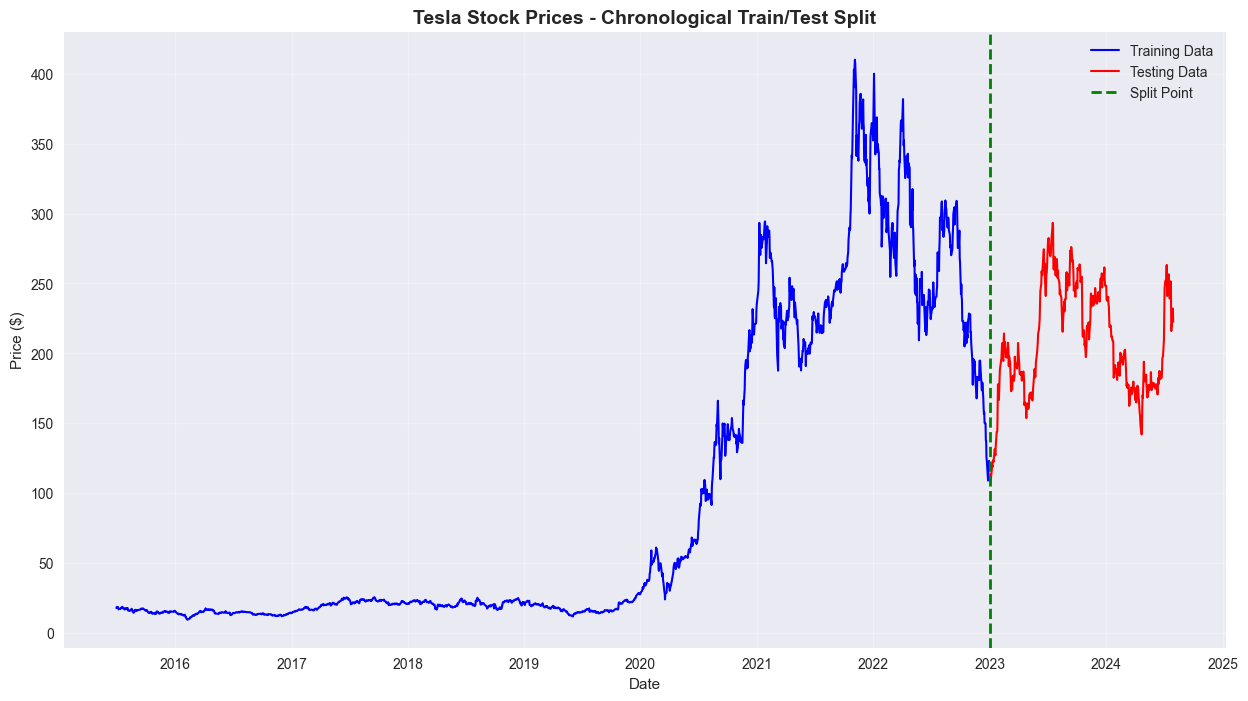

In [20]:
# Chronological train-test split (2015-2023 train, 2023-2025 test)
split_date = '2023-01-01'

train_prices = tsla_prices[tsla_prices.index < split_date]
test_prices = tsla_prices[tsla_prices.index >= split_date]
train_returns = tsla_daily_returns[tsla_daily_returns.index < split_date]
test_returns = tsla_daily_returns[tsla_daily_returns.index >= split_date]

print("Chronological data split completed:")
print(f"Training period: {train_prices.index.min()} to {train_prices.index.max()}")
print(f"Testing period: {test_prices.index.min()} to {test_prices.index.max()}")
print(f"Training samples: {len(train_prices)} ({len(train_prices)/len(tsla_prices)*100:.1f}%)")
print(f"Testing samples: {len(test_prices)} ({len(test_prices)/len(tsla_prices)*100:.1f}%)")

# Visualize the split
plt.figure(figsize=(15, 8))
plt.plot(train_prices.index, train_prices.values, label='Training Data', color='blue', linewidth=1.5)
plt.plot(test_prices.index, test_prices.values, label='Testing Data', color='red', linewidth=1.5)
plt.axvline(x=pd.to_datetime(split_date), color='green', linestyle='--', linewidth=2, label='Split Point')
plt.title('Tesla Stock Prices - Chronological Train/Test Split', fontsize=14, fontweight='bold')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [21]:
# ARIMA Model Implementation with Manual Parameter Selection

def check_stationarity(timeseries, title):
    """Perform Augmented Dickey-Fuller test for stationarity"""
    print(f'\\nStationarity Test for {title}:')
    print('='*50)
    
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations'])
    
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    
    print(dfoutput)
    
    if dftest[1] <= 0.05:
        print("\\nResult: Series is STATIONARY ✅")
        return True
    else:
        print("\\nResult: Series is NON-STATIONARY ⚠️")
        return False

def find_best_arima_manual(data, max_p=3, max_q=3):
    """Manual ARIMA parameter selection using AIC"""
    best_aic = np.inf
    best_order = None
    best_model = None
    
    print("\\nPerforming manual ARIMA parameter search...")
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = ARIMA(data, order=(p, 0, q))  # d=0 for stationary returns
                fitted_model = model.fit()
                aic = fitted_model.aic
                
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, 0, q)
                    best_model = fitted_model
                    
                print(f"ARIMA({p},0,{q}): AIC = {aic:.2f}")
                
            except Exception as e:
                print(f"ARIMA({p},0,{q}): Failed")
                continue
    
    return best_model, best_order, best_aic

# Check stationarity and select data for ARIMA
price_stationary = check_stationarity(train_prices, "Tesla Prices")
returns_stationary = check_stationarity(train_returns, "Tesla Returns")

# Use returns for ARIMA (should be stationary)
arima_data = train_returns.copy()
print(f"\\nUsing daily returns for ARIMA modeling (stationary series)")

# Find best ARIMA parameters
arima_model, best_order, best_aic = find_best_arima_manual(arima_data.dropna())
print(f"\\nBest ARIMA model: {best_order}")
print(f"Best AIC: {best_aic:.2f}")
print("\\nARIMA Model Summary:")
print(arima_model.summary())


\nStationarity Test for Tesla Prices:
Test Statistic            -1.335401
p-value                    0.612825
Lags Used                 24.000000
Observations            1865.000000
Critical Value (1%)       -3.433861
Critical Value (5%)       -2.863091
Critical Value (10%)      -2.567596
dtype: float64
\nResult: Series is NON-STATIONARY ⚠️
\nStationarity Test for Tesla Returns:
Test Statistic           -29.521907
p-value                    0.000000
Lags Used                  1.000000
Observations            1887.000000
Critical Value (1%)       -3.433820
Critical Value (5%)       -2.863073
Critical Value (10%)      -2.567586
dtype: float64
\nResult: Series is STATIONARY ✅
\nUsing daily returns for ARIMA modeling (stationary series)
\nPerforming manual ARIMA parameter search...
ARIMA(0,0,0): AIC = -7140.75
ARIMA(0,0,1): AIC = -7138.77
ARIMA(0,0,2): AIC = -7139.90
ARIMA(0,0,3): AIC = -7139.33
ARIMA(1,0,0): AIC = -7138.78
ARIMA(1,0,1): AIC = -7137.25
ARIMA(1,0,2): AIC = -7137.97
ARIMA(1,

ARIMA forecast completed for 395 periods
Forecast statistics:
  Mean return forecast: 0.001707
  Std return forecast: 0.000513
\nPrice forecast conversion:
Starting price: $123.18
Final predicted price: $241.60
Actual final price: $222.62
Prediction error: $18.98


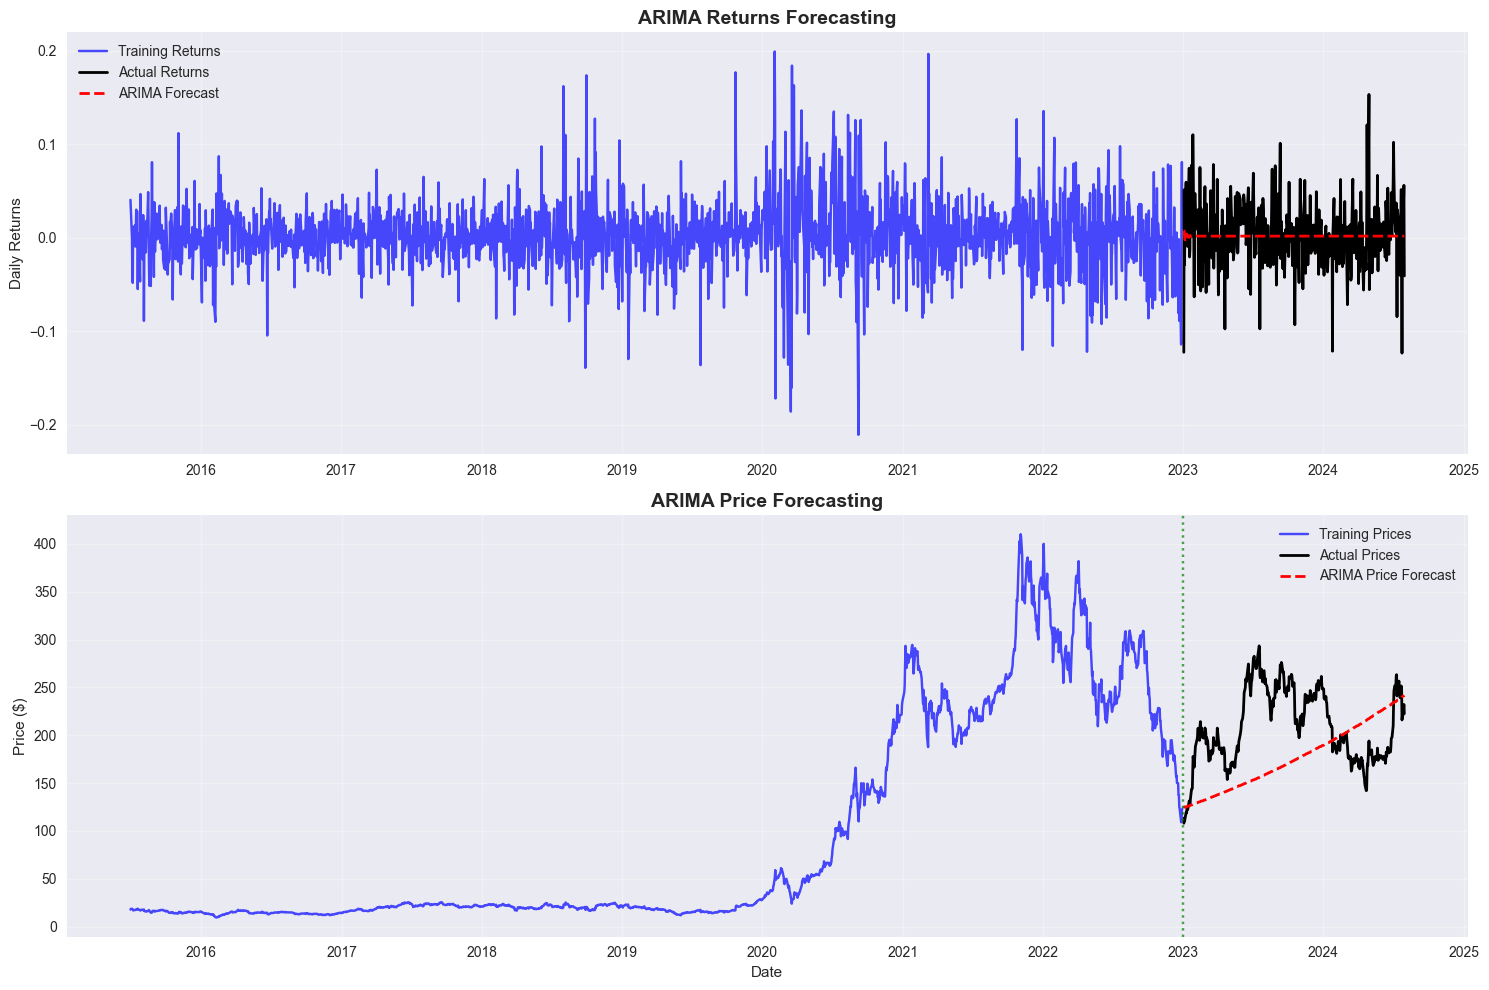

In [22]:
# ARIMA Forecasting and Price Conversion

# Generate forecasts for test period
n_forecast = len(test_returns)
arima_forecast = arima_model.forecast(steps=n_forecast)

print(f"ARIMA forecast completed for {n_forecast} periods")
print(f"Forecast statistics:")
print(f"  Mean return forecast: {arima_forecast.mean():.6f}")
print(f"  Std return forecast: {arima_forecast.std():.6f}")

# Convert return forecasts back to price forecasts
last_train_price = train_prices.iloc[-1]
arima_price_forecast = []
current_price = last_train_price

for return_forecast in arima_forecast:
    # Price(t) = Price(t-1) * (1 + return(t))
    current_price = current_price * (1 + return_forecast)
    arima_price_forecast.append(current_price)

# Create forecast dataframes
arima_price_forecast_df = pd.DataFrame({
    'arima_price_forecast': arima_price_forecast
}, index=test_prices.index)

print(f"\\nPrice forecast conversion:")
print(f"Starting price: ${last_train_price:.2f}")
print(f"Final predicted price: ${arima_price_forecast[-1]:.2f}")
print(f"Actual final price: ${test_prices.iloc[-1]:.2f}")
print(f"Prediction error: ${abs(arima_price_forecast[-1] - test_prices.iloc[-1]):.2f}")

# Plot ARIMA results
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(train_returns.index, train_returns.values, label='Training Returns', color='blue', alpha=0.7)
plt.plot(test_returns.index, test_returns.values, label='Actual Returns', color='black', linewidth=2)
plt.plot(test_returns.index, arima_forecast, label='ARIMA Forecast', color='red', linewidth=2, linestyle='--')
plt.title('ARIMA Returns Forecasting', fontsize=14, fontweight='bold')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(train_prices.index, train_prices.values, label='Training Prices', color='blue', alpha=0.7)
plt.plot(test_prices.index, test_prices.values, label='Actual Prices', color='black', linewidth=2)
plt.plot(arima_price_forecast_df.index, arima_price_forecast_df['arima_price_forecast'], 
         label='ARIMA Price Forecast', color='red', linewidth=2, linestyle='--')
plt.axvline(x=pd.to_datetime(split_date), color='green', linestyle=':', alpha=0.7)
plt.title('ARIMA Price Forecasting', fontsize=14, fontweight='bold')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [23]:
# LSTM Model Implementation

def create_lstm_dataset(data, look_back=60):
    """Create dataset for LSTM with specified look-back window"""
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Prepare LSTM data
print("Preparing LSTM data...")

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(tsla_prices.values.reshape(-1, 1))

# Split scaled data
train_size = len(train_prices)
scaled_train = scaled_prices[:train_size]
scaled_test = scaled_prices[train_size:]

# Create LSTM datasets with 60-day lookback
look_back = 60
X_train, y_train = create_lstm_dataset(scaled_train.flatten(), look_back)

# For test set, use last look_back days from training + test data
extended_data = np.concatenate([scaled_train[-look_back:], scaled_test])
X_test, y_test = create_lstm_dataset(extended_data.flatten(), look_back)

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("LSTM data preparation completed:")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Look-back window: {look_back} days")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Build LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    return model

# Create and compile model
lstm_model = create_lstm_model((look_back, 1))
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print("\\nLSTM Model Architecture:")
print("="*50)
lstm_model.summary()


Preparing LSTM data...
LSTM data preparation completed:
Training samples: 1830
Testing samples: 395
Look-back window: 60 days
X_train shape: (1830, 60, 1)
X_test shape: (395, 60, 1)
\nLSTM Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Training LSTM model...
This may take several minutes...
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0122 - mae: 0.0562 - val_loss: 0.0049 - val_mae: 0.0560
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0027 - mae: 0.0259 - val_loss: 0.0125 - val_mae: 0.0967
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0026 - mae: 0.0250 - val_loss: 0.0037 - val_mae: 0.0493
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023 - mae: 0.0238 - val_loss: 0.0091 - val_mae: 0.0805
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0024 - mae: 0.0240 - val_loss: 0.0033 - val_mae: 0.0467
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019 - mae: 0.0219 - val_loss: 0.0051 - val_mae: 0.0579
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018 - mae: 0.0215 - val_loss: 0.0032 - val_mae: 0.0458
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019 - mae: 0.0219 - val_loss: 0.0036 - val_mae: 0.0483
Epoch 9/

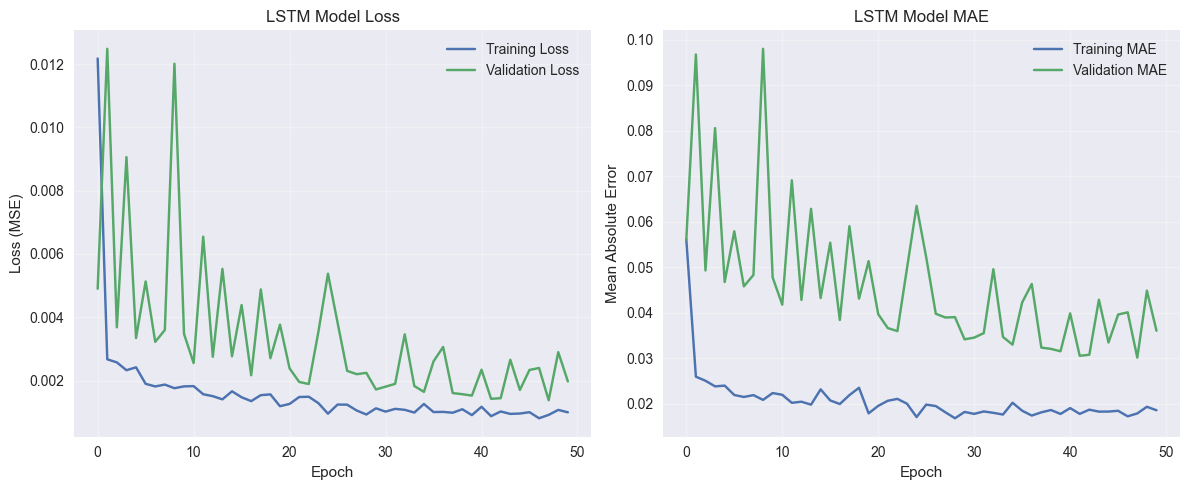

\nGenerating LSTM forecasts...
LSTM forecasts generated for 395 periods
Final predicted price: $225.28


In [24]:
# Train LSTM Model

print("Training LSTM model...")
print("This may take several minutes...")

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

print(f"\\nLSTM training completed!")
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('LSTM Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Generate LSTM predictions
print("\\nGenerating LSTM forecasts...")
lstm_predictions_scaled = lstm_model.predict(X_test, verbose=0)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

# Create LSTM forecast dataframe
lstm_forecast_df = pd.DataFrame({
    'lstm_price_forecast': lstm_predictions.flatten()
}, index=test_prices.index)

print(f"LSTM forecasts generated for {len(lstm_predictions)} periods")
print(f"Final predicted price: ${lstm_forecast_df['lstm_price_forecast'].iloc[-1]:.2f}")


Model Performance Comparison
           MAE     RMSE  MAPE (%)      R²  Directional Accuracy (%)
Model                                                              
ARIMA  51.7738  60.3427    23.855 -1.3896                   52.2843
LSTM    8.1879  10.7756     4.002  0.9238                   50.5076
\nModel Rankings:
MAE: LSTM wins
RMSE: LSTM wins
MAPE (%): LSTM wins
\nOverall Winner: LSTM (3/3 metrics)


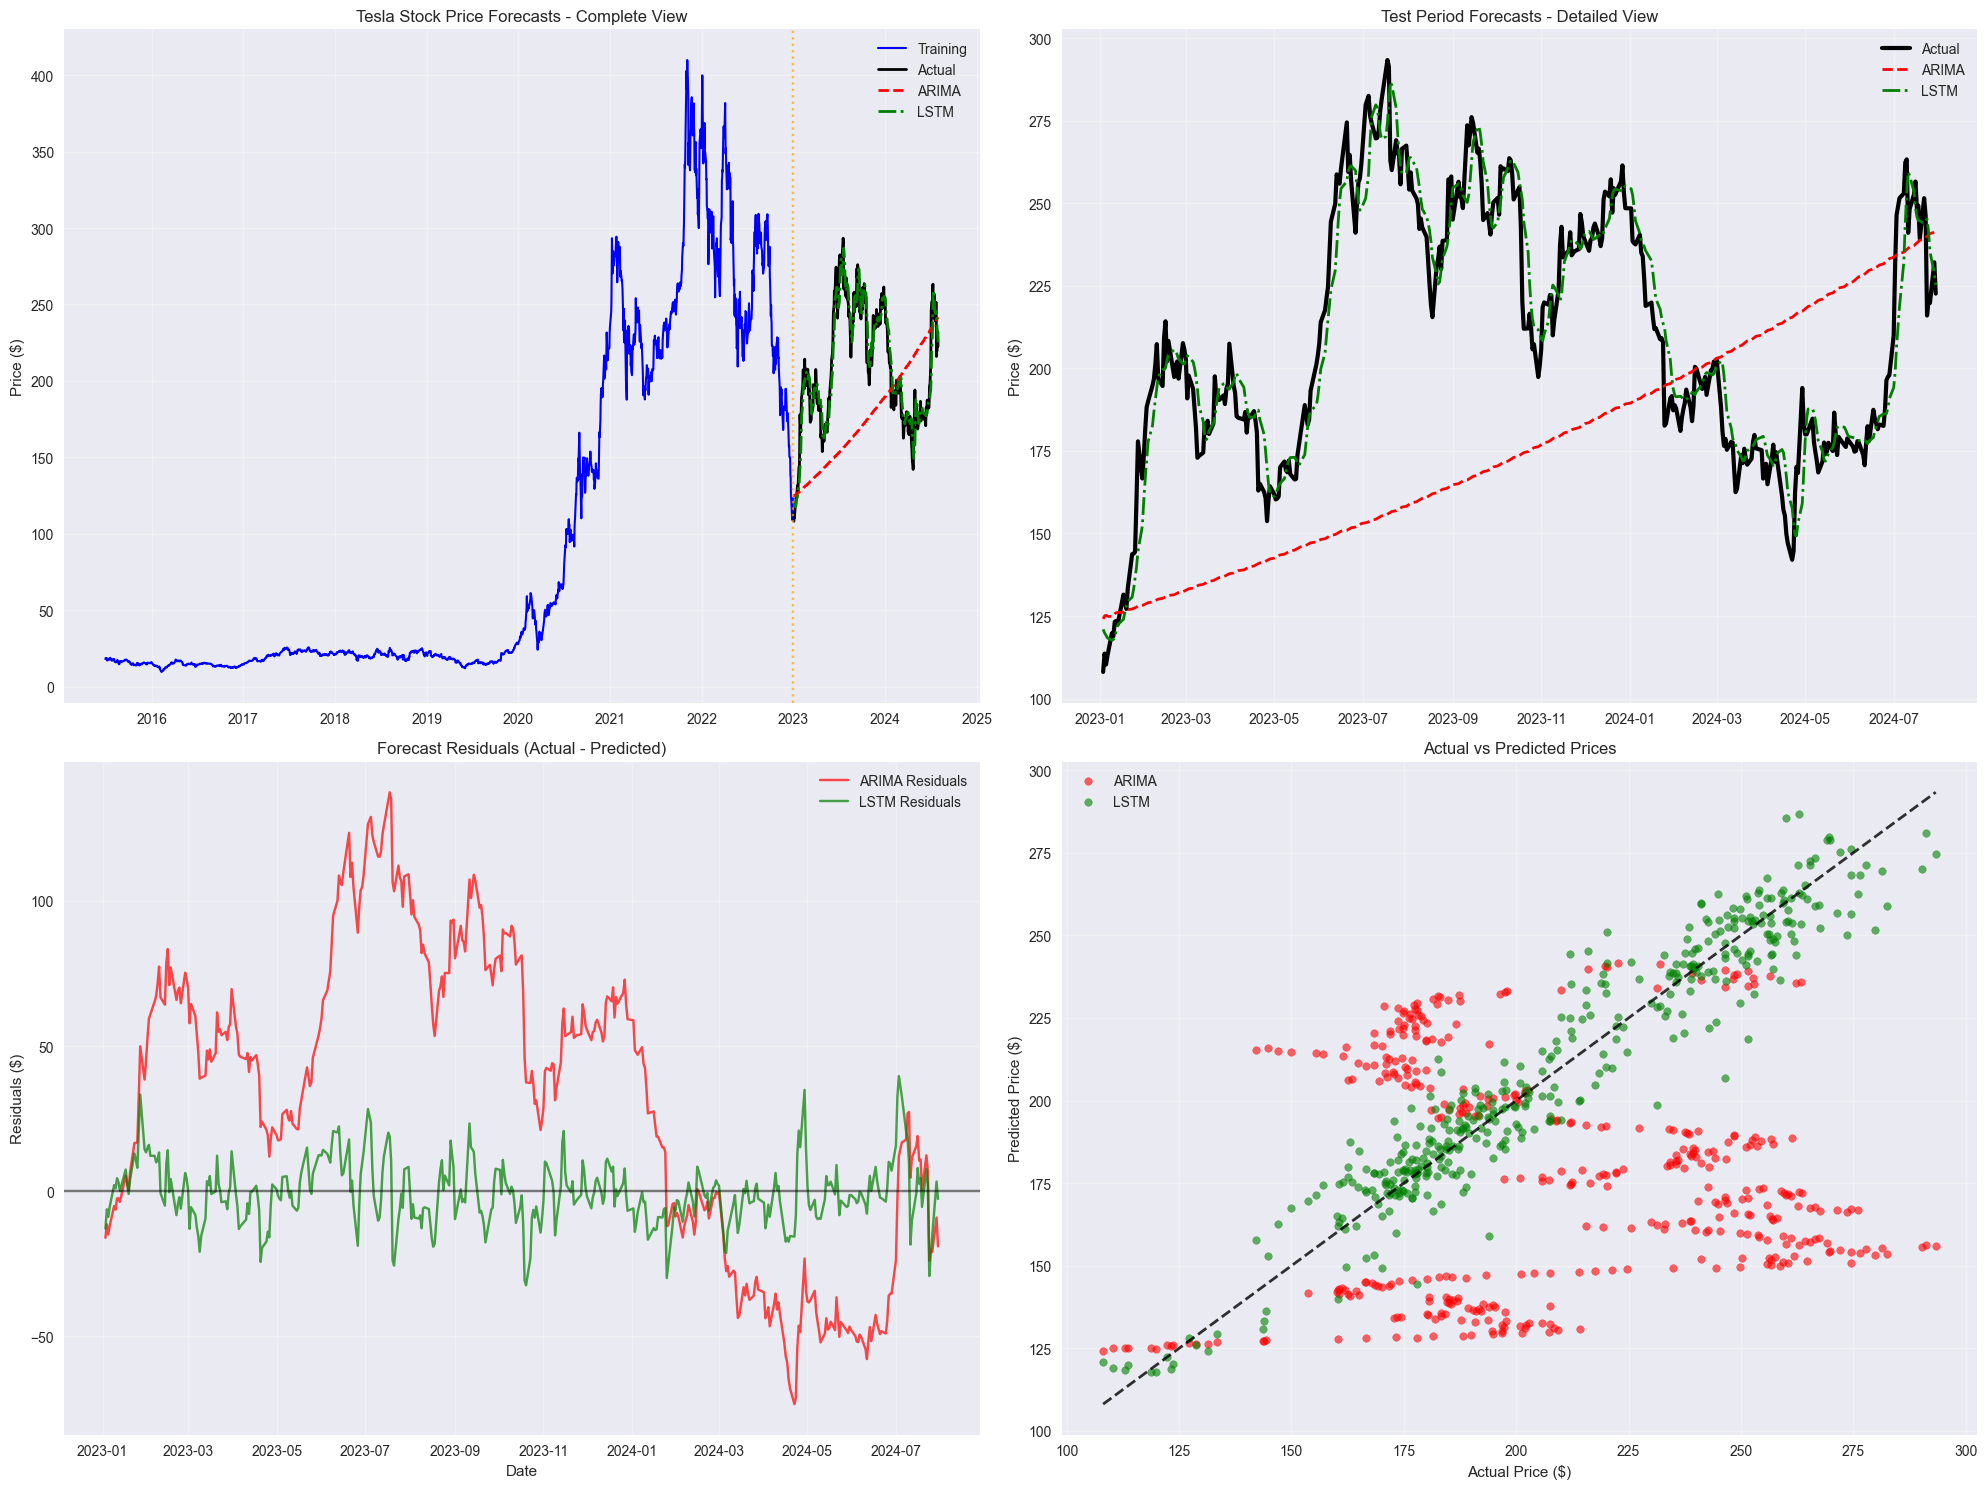

In [25]:
# Model Evaluation and Comparison

def calculate_metrics(actual, predicted, model_name):
    """Calculate comprehensive evaluation metrics"""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    # Directional accuracy
    actual_direction = np.diff(actual) > 0
    predicted_direction = np.diff(predicted) > 0
    directional_accuracy = np.mean(actual_direction == predicted_direction) * 100
    
    # R-squared
    ss_res = np.sum((actual - predicted) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'R²': r2,
        'Directional Accuracy (%)': directional_accuracy
    }

# Calculate metrics for both models
actual_test_prices = test_prices.values
arima_metrics = calculate_metrics(actual_test_prices, arima_price_forecast_df['arima_price_forecast'].values, 'ARIMA')
lstm_metrics = calculate_metrics(actual_test_prices, lstm_forecast_df['lstm_price_forecast'].values, 'LSTM')

# Create comparison table
comparison_df = pd.DataFrame([arima_metrics, lstm_metrics]).set_index('Model')

print("Model Performance Comparison")
print("="*60)
print(comparison_df.round(4))

# Determine best model by key metrics
metrics_to_rank = ['MAE', 'RMSE', 'MAPE (%)']
rankings = {}

for metric in metrics_to_rank:
    if comparison_df[metric]['ARIMA'] < comparison_df[metric]['LSTM']:
        rankings[metric] = 'ARIMA'
    else:
        rankings[metric] = 'LSTM'

print("\\nModel Rankings:")
for metric, winner in rankings.items():
    print(f"{metric}: {winner} wins")

arima_wins = sum(1 for winner in rankings.values() if winner == 'ARIMA')
lstm_wins = sum(1 for winner in rankings.values() if winner == 'LSTM')
print(f"\\nOverall Winner: {'ARIMA' if arima_wins > lstm_wins else 'LSTM'} ({max(arima_wins, lstm_wins)}/{len(metrics_to_rank)} metrics)")

# Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Plot 1: Complete forecasts
ax1 = axes[0, 0]
ax1.plot(train_prices.index, train_prices.values, label='Training', color='blue', linewidth=1.5)
ax1.plot(test_prices.index, test_prices.values, label='Actual', color='black', linewidth=2)
ax1.plot(arima_price_forecast_df.index, arima_price_forecast_df['arima_price_forecast'], 
         label='ARIMA', color='red', linewidth=2, linestyle='--')
ax1.plot(lstm_forecast_df.index, lstm_forecast_df['lstm_price_forecast'], 
         label='LSTM', color='green', linewidth=2, linestyle='-.')
ax1.axvline(x=pd.to_datetime(split_date), color='orange', linestyle=':', alpha=0.7)
ax1.set_title('Tesla Stock Price Forecasts - Complete View')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Test period detail
ax2 = axes[0, 1]
ax2.plot(test_prices.index, test_prices.values, label='Actual', color='black', linewidth=3)
ax2.plot(arima_price_forecast_df.index, arima_price_forecast_df['arima_price_forecast'], 
         label='ARIMA', color='red', linewidth=2, linestyle='--')
ax2.plot(lstm_forecast_df.index, lstm_forecast_df['lstm_price_forecast'], 
         label='LSTM', color='green', linewidth=2, linestyle='-.')
ax2.set_title('Test Period Forecasts - Detailed View')
ax2.set_ylabel('Price ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals
ax3 = axes[1, 0]
arima_residuals = actual_test_prices - arima_price_forecast_df['arima_price_forecast'].values
lstm_residuals = actual_test_prices - lstm_forecast_df['lstm_price_forecast'].values
ax3.plot(test_prices.index, arima_residuals, label='ARIMA Residuals', color='red', alpha=0.7)
ax3.plot(test_prices.index, lstm_residuals, label='LSTM Residuals', color='green', alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax3.set_title('Forecast Residuals (Actual - Predicted)')
ax3.set_ylabel('Residuals ($)')
ax3.set_xlabel('Date')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Actual vs Predicted scatter
ax4 = axes[1, 1]
ax4.scatter(actual_test_prices, arima_price_forecast_df['arima_price_forecast'].values, 
           alpha=0.6, color='red', label='ARIMA', s=30)
ax4.scatter(actual_test_prices, lstm_forecast_df['lstm_price_forecast'].values, 
           alpha=0.6, color='green', label='LSTM', s=30)
min_price = min(actual_test_prices.min(), arima_price_forecast_df['arima_price_forecast'].min(), 
                lstm_forecast_df['lstm_price_forecast'].min())
max_price = max(actual_test_prices.max(), arima_price_forecast_df['arima_price_forecast'].max(), 
                lstm_forecast_df['lstm_price_forecast'].max())
ax4.plot([min_price, max_price], [min_price, max_price], 'k--', alpha=0.8, linewidth=2)
ax4.set_title('Actual vs Predicted Prices')
ax4.set_xlabel('Actual Price ($)')
ax4.set_ylabel('Predicted Price ($)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [26]:
# Save Results and Model Artifacts

print("Saving forecasting results and models...")

# Combine forecasts into single dataframe
all_forecasts = pd.DataFrame({
    'actual_prices': test_prices.values,
    'arima_forecast': arima_price_forecast_df['arima_price_forecast'].values,
    'lstm_forecast': lstm_forecast_df['lstm_price_forecast'].values
}, index=test_prices.index)

# Save results
all_forecasts.to_csv(f'{data_path}task2_forecasts.csv')
comparison_df.to_csv(f'{data_path}task2_model_comparison.csv')

# Save models
lstm_model.save(f'{models_path}lstm_tesla_forecast.h5')

import joblib
joblib.dump(scaler, f'{models_path}price_scaler.pkl')

import pickle
with open(f'{models_path}arima_tesla_forecast.pkl', 'wb') as f:
    pickle.dump(arima_model, f)

print("✅ Results saved:")
print(f"  • {data_path}task2_forecasts.csv")
print(f"  • {data_path}task2_model_comparison.csv")
print(f"  • {models_path}lstm_tesla_forecast.h5")
print(f"  • {models_path}price_scaler.pkl")
print(f"  • {models_path}arima_tesla_forecast.pkl")

# Task 2 Summary
print("\\n" + "="*70)
print("TASK 2: TIME SERIES FORECASTING MODELS - COMPLETED")
print("="*70)

print(f"\\n📊 DATA PREPARATION:")
print(f"• Training Period: {train_prices.index.min()} to {train_prices.index.max()}")
print(f"• Testing Period: {test_prices.index.min()} to {test_prices.index.max()}")
print(f"• Training Samples: {len(train_prices):,} ({len(train_prices)/len(tsla_prices)*100:.1f}%)")
print(f"• Testing Samples: {len(test_prices):,} ({len(test_prices)/len(tsla_prices)*100:.1f}%)")

print(f"\\n🔍 MODEL IMPLEMENTATIONS:")
print(f"• ARIMA Model: {best_order} (Manual parameter selection)")
print(f"• LSTM Model: 3-layer architecture with {lstm_model.count_params():,} parameters")
print(f"• LSTM Look-back: {look_back} days")

print(f"\\n📈 PERFORMANCE COMPARISON:")
for index, row in comparison_df.iterrows():
    print(f"• {index} Model:")
    print(f"  - MAE: ${row['MAE']:.2f}")
    print(f"  - RMSE: ${row['RMSE']:.2f}")
    print(f"  - MAPE: {row['MAPE (%)']:.2f}%")
    print(f"  - R²: {row['R²']:.4f}")

best_mae_model = comparison_df.loc[comparison_df['MAE'].idxmin()]
print(f"\\n🏆 BEST MODEL (MAE): {best_mae_model.name} (${best_mae_model['MAE']:.2f})")

print(f"\\n📁 DELIVERABLES:")
print("• Tesla price forecasts for 2023-2025 test period")
print("• ARIMA model with manual parameter optimization")
print("• LSTM model with 60-day sequence learning")
print("• Comprehensive performance comparison")
print("• Saved model artifacts for Task 3")

print(f"\\n✅ READY FOR TASK 3: FORECAST FUTURE MARKET TRENDS")


Saving forecasting results and models...
✅ Results saved:
  • ../data/processed/task2_forecasts.csv
  • ../data/processed/task2_model_comparison.csv
  • ../models/lstm_tesla_forecast.h5
  • ../models/price_scaler.pkl
  • ../models/arima_tesla_forecast.pkl
\n======================================================================
TASK 2: TIME SERIES FORECASTING MODELS - COMPLETED
\n📊 DATA PREPARATION:
• Training Period: 2015-07-01 00:00:00 to 2022-12-30 00:00:00
• Testing Period: 2023-01-03 00:00:00 to 2024-07-30 00:00:00
• Training Samples: 1,890 (82.7%)
• Testing Samples: 395 (17.3%)
\n🔍 MODEL IMPLEMENTATIONS:
• ARIMA Model: (2, 0, 2) (Manual parameter selection)
• LSTM Model: 3-layer architecture with 50,851 parameters
• LSTM Look-back: 60 days
\n📈 PERFORMANCE COMPARISON:
• ARIMA Model:
  - MAE: $51.77
  - RMSE: $60.34
  - MAPE: 23.85%
  - R²: -1.3896
• LSTM Model:
  - MAE: $8.19
  - RMSE: $10.78
  - MAPE: 4.00%
  - R²: 0.9238
\n🏆 BEST MODEL (MAE): LSTM ($8.19)
\n📁 DELIVERABLES:
• Tesl